In [1]:
import os
import random

import cv2
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np

from handwriting_generator import HandwritingGenerator, default_config

fonts_dir = "../fonts"

In [2]:
config = deepcopy(default_config)
config["font_name"] = os.path.join(fonts_dir, "Gogol.ttf")
text_generator = HandwritingGenerator(config=config)

text = "Аугментация"

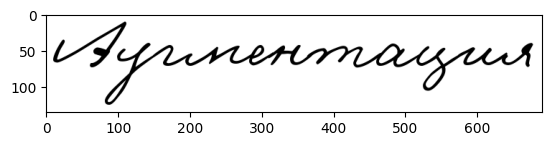

In [3]:
word_img = text_generator.write_word(text)
plt.imshow(word_img)

# Skew

In [4]:
def skew(angle: float, img: np.ndarray) -> np.ndarray:
    """
    img should have 3 dimensions and white background
    :param angle: angle to rotate in radians
    :param img: image to change
    :return: changed image
    """
    img2 = deepcopy(img)
    img2 = 255 - img2

    if angle > 0:
        img2 = np.concatenate([img2, np.zeros([img2.shape[0], int(img2.shape[0] * angle), 3])], axis=1)
    else:
        img2 = np.concatenate([np.zeros([img2.shape[0], int(img2.shape[0] * (-angle)), 3]), img2], axis=1)

    M = np.float32([[1, -angle, 0], [0, 1, 0]])
    out_img = cv2.warpAffine(img2, M, (img2.shape[1], img2.shape[0]), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
    out_img = 255 - out_img
    return out_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


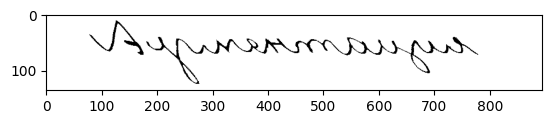

In [5]:
plt.imshow(skew(1.5, word_img))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


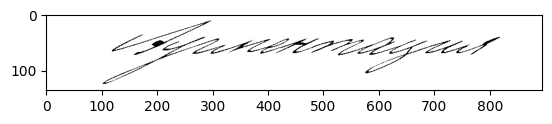

In [6]:
plt.imshow(skew(-1.5, word_img))

# Change width

In [7]:
def change_width(proportion: float, img: np.ndarray) -> np.ndarray:
    new_width = int(img.shape[1] * proportion)
    out_img = cv2.resize(img, (new_width, img.shape[0]), interpolation=cv2.INTER_AREA)
    return out_img

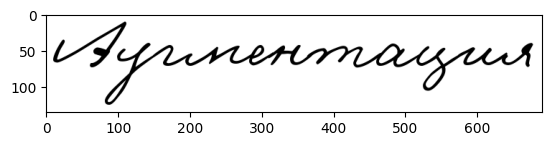

In [8]:
plt.imshow(word_img)

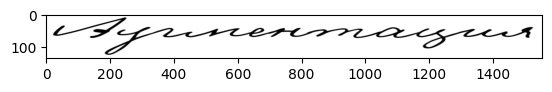

In [9]:
plt.imshow(change_width(2.25, word_img))

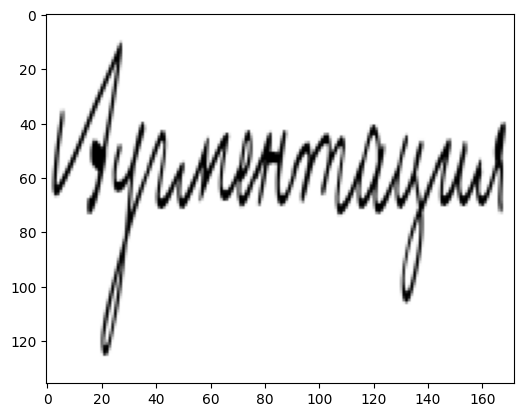

In [10]:
plt.imshow(change_width(0.25, word_img))

# Blots

In [11]:
from augmixations import HandWrittenBlot

def blot(blots_num: int, img: np.ndarray) -> np.ndarray:
    b = HandWrittenBlot(
        {'x': (None, None), 'y': (None, None), 'h': (50, 100), 'w': (40, 100)},
        {'incline': (10, 50), 'intensivity': (0.75, 0.75), 'transparency': (0.05, 0.4), 'count': blots_num}
    )
    return b.apply(img)

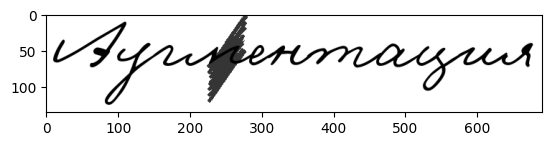

In [12]:
plt.imshow(blot(1, word_img))

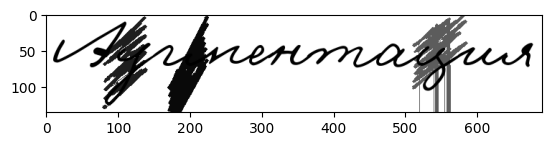

In [13]:
plt.imshow(blot(3, word_img))

# Blur

In [14]:
def blur(max_blur: int, img: np.ndarray) -> np.ndarray:
    return cv2.blur(img, (random.randint(1, max_blur), random.randint(1, max_blur)))

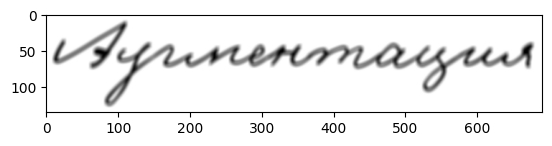

In [15]:
plt.imshow(blur(10, word_img))

# Background

* gradient fill (random threshold)
* lined or squared (optional)
* stains or dots (optional)
* adding cut characters along the edges (optional)

In [16]:
def fill_gradient(img: np.ndarray, color: tuple, rotate: int, light: bool = False) -> np.ndarray:
    square_img = np.ones((img.shape[1], img.shape[1], 3), dtype=np.uint8) * 255
    text_mask = np.where(img == 0, 0, 1)

    gradient_mask = np.rot90(np.repeat(np.tile(np.linspace(1, 0, square_img.shape[0]), (square_img.shape[0], 1))[:, :, np.newaxis], 3, axis=2), rotate)
    square_img[:, :, :] = gradient_mask * square_img + (1 - gradient_mask) * color
    img = cv2.resize(square_img, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_AREA) * text_mask

    return img

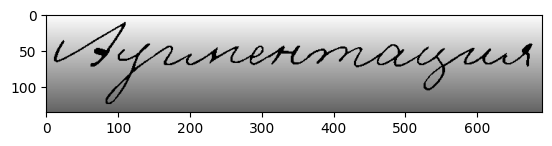

In [17]:
plt.imshow(fill_gradient(word_img, (100, 100, 100), 3))


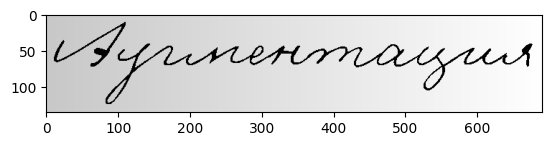

In [18]:
plt.imshow(fill_gradient(word_img, (200, 200, 200), 2))

In [19]:
from sklearn import linear_model

def detect_baseline(img: np.ndarray, threshold: int = 20) -> int:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = 255 - img
    low = []
    for w in range(1, img.shape[1] - 1):
        if np.max(img[:, w]) <= threshold:
            continue
        for h in range(img.shape[0] - 5, 0, -1):
            if img[h, w] > threshold:
                low += [[h, w]]
                break
    points_lower = np.array(low)
    x = points_lower[:, 1].reshape(points_lower.shape[0], 1)
    y = points_lower[:, 0].reshape(points_lower.shape[0], 1)
    model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
    model_ransac.fit(x, y)
    y_mean = model_ransac.predict(np.array([img.shape[1] / 2]).reshape(1, -1))
    return int(y_mean)

In [20]:
def draw_lines(img: np.ndarray, color: tuple, thickness: int, lines_type: int = 0, line_width: int = 3) -> np.ndarray:
    y1 = detect_baseline(img)
    y2 = img.shape[0] - detect_baseline(np.rot90(img, 2))
    delta = (y1 - y2) * line_width

    new_img = deepcopy(img)
    text_mask = np.where(img == 0, 0, 1)
    y = y1
    while y > 0:
        y -= delta
    while y < new_img.shape[0]:
        new_img = cv2.line(new_img, (0, y), (new_img.shape[1], y), color=color, thickness=thickness)
        y += delta

    if lines_type == 0:
        return new_img * text_mask

    x = random.randint(0, delta)
    while x < new_img.shape[1]:
        new_img = cv2.line(new_img, (x, 0), (x, new_img.shape[0]), color=color, thickness=thickness)
        x += delta

    return new_img * text_mask

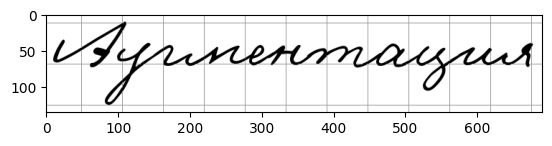

In [21]:
plt.imshow(draw_lines(word_img, (150, 150, 150), thickness=1, lines_type=1))

In [22]:
def add_noise(img: np.ndarray, max_dots: int, min_color: int, max_color: int) -> np.ndarray:
    number_of_pixels = random.randint(0, max_dots)
    new_img = deepcopy(img)

    for i in range(number_of_pixels):
        y_coord = random.randint(0, new_img.shape[0] - 1)
        x_coord = random.randint(0, new_img.shape[1] - 1)
        color = random.randint(min_color, max_color)
        new_img[y_coord][x_coord] = (color, color, color)

        if random.random() < 0.5 and y_coord - 1 > 0:
            new_img[y_coord - 1][x_coord] = (color, color, color)
        if random.random() < 0.5 and x_coord - 1 > 0:
            new_img[y_coord][x_coord - 1] = (color, color, color)
        if random.random() < 0.5 and y_coord + 1 < new_img.shape[0]:
            new_img[y_coord + 1][x_coord] = (color, color, color)
        if random.random() < 0.5 and x_coord + 1 < new_img.shape[1]:
            new_img[y_coord][x_coord + 1] = (color, color, color)

    return new_img

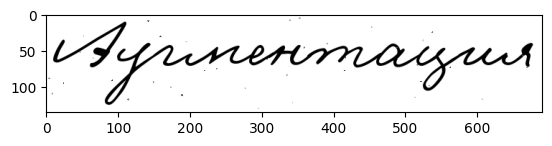

In [23]:
plt.imshow(add_noise(word_img, 100, 0, 200))

In [24]:
from numpy.random import default_rng
import skimage.exposure


def add_stains(img: np.ndarray, color: int, seed: int = 75) -> np.ndarray:
    text_mask = np.where(img == 0, 0, 1)
    rng = default_rng(seed=seed)
    noise = rng.integers(0, 255, (img.shape[0], img.shape[1]), np.uint8, True)
    blur = cv2.GaussianBlur(noise, (0,0), sigmaX=15, sigmaY=15, borderType = cv2.BORDER_DEFAULT)
    stretch = skimage.exposure.rescale_intensity(blur, in_range='image', out_range=(0,255)).astype(np.uint8)
    thresh = cv2.threshold(stretch, 175, 255, cv2.THRESH_BINARY)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
    mask = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.merge([mask, mask, mask])
    result = np.where(mask > 0, color, img)
    return result * text_mask

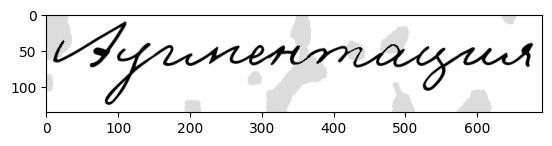

In [25]:
plt.imshow(add_stains(word_img, 220, 120))

In [48]:
def add_blurred_stains(img: np.ndarray, seed: int = 75) -> np.ndarray:
    text_mask = np.where(img == 0, 0, 1)
    rng = default_rng(seed=seed)
    noise = rng.integers(0, 255, (img.shape[0], img.shape[1]), np.uint8, True)
    blur = cv2.GaussianBlur(noise, (0, 0), sigmaX=15, sigmaY=15, borderType=cv2.BORDER_DEFAULT)

    img = cv2.merge([blur, blur, blur]) / 255.
    img = ((img - img.min()) * 255. / (img.max() - img.min())).astype(np.uint8)
    return img * text_mask

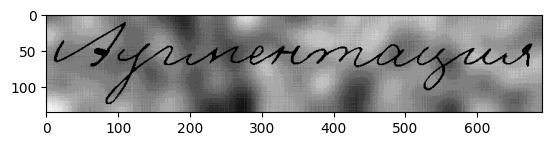

In [49]:
plt.imshow(add_blurred_stains(word_img))